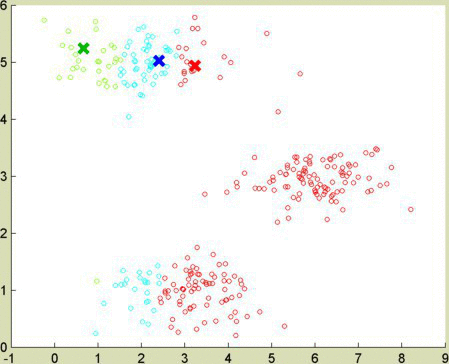

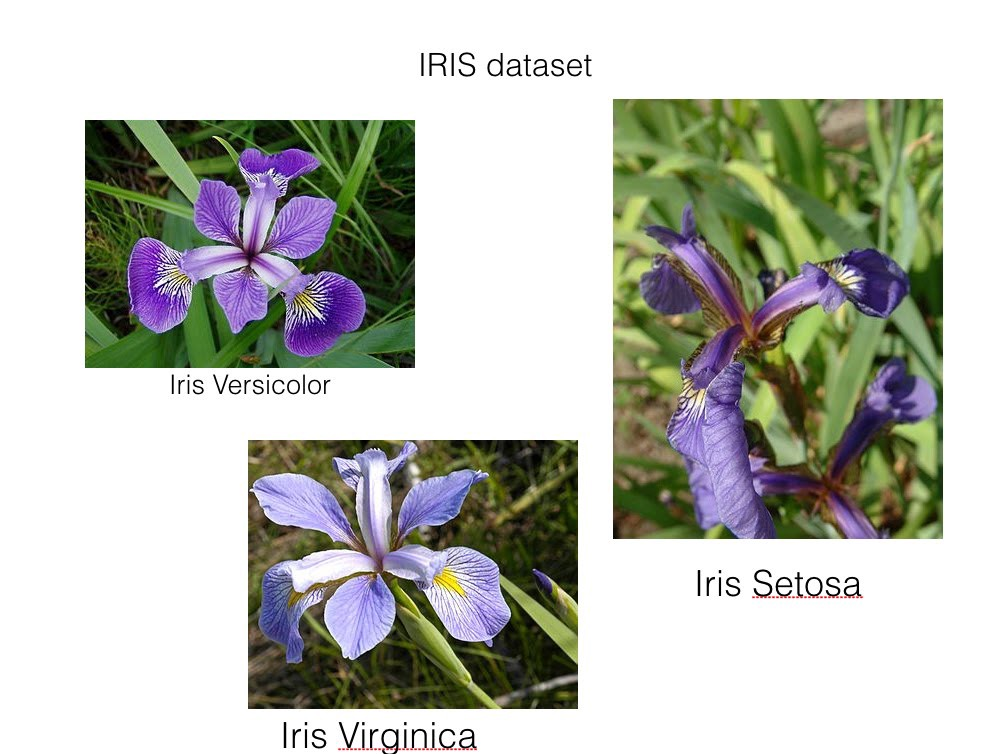

In [125]:
using CSV, DataFrames, Plots, StatPlots, Distances;
plotly();

if nprocs() < 3
    addprocs(3);
end

@everywhere using Distances;

In [126]:
iris = CSV.read("iris.csv")

iris[:class] = iris[:class]
head(iris)

,sepal_length,sepal_width,petal_length,petal_width,class
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa


In [127]:
@everywhere function dist(x, y)
    sqrt.(sum((x .- transpose(y)).^2, 2))
end

Xy = convert(Array, iris[:, filter(x -> (x in [:petal_length, :sepal_width, :petal_width, :class]), names(iris))])
X = convert(Array{Float64}, Xy[:, 1:3])
y = Xy[:, 4];

In [128]:
function match_classes(X, C)
    classes = convert(SharedArray, zeros(size(X, 1)))
        
    @sync @parallel for i = 1:size(X, 1)
        x = X[i, :]
        classes[i] = indmin(dist(C, x))
    end
    classes
end

function k_means(X, k)
    maxes = findmax(X, 1)[1]
    C = convert(SharedArray, rand(k, size(maxes, 1)) .* maxes)

    error = 1

    while error != 0
        C_old = copy(C)
        
        classes = match_classes(X, C)

        for i = 1:k
            Xs = [X[j, :] for j = 1:size(X, 1) if classes[j] == i]
            if size(Xs, 1) > 0
                C[i, :] = mean(Xs)
            else
                C[i, :] = rand(1, size(maxes, 1)) .* maxes
            end
        end  
        scatter(X[:, 1], X[:, 2],X[:, 3], group=classes, markersize=2)
        display(scatter!(C[:,1],C[:,2], C[:,3], markersize=8, alpha=0.8))
        error = euclidean(C, C_old)
    end
    C
end;

In [129]:
@time C = k_means(X, 3)
classes = match_classes(X, C);

  0.851011 seconds (1.78 M allocations: 48.935 MiB, 2.42% gc time)


In [130]:
scatter(X[:, 1], X[:, 2],X[:, 3],  group=y, markersize=2)

In [131]:
scatter(X[:, 1], X[:, 2],X[:, 3], group=classes, markersize=2, legend=false)
scatter!(C[:,1],C[:,2], C[:,3], markersize=8, alpha=0.8)